# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
#Load different modules necessary for project
from __future__ import print_function
import h5py
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import random
from random import randint
import matplotlib.pyplot as plt
from itertools import combinations
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Activation, Convolution2D, Flatten,MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical
from skimage.transform import resize
from PIL import Image
from matplotlib.pyplot import imshow, show
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Input, LSTM, Dense, merge
from keras.models import Model
from keras import backend as K

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

random.seed(42)

train_folder = '/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/train/'
test_folder = '/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/test/'
new_folder = '/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/houses/'

image_size = 64  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
num_channels = 3 # default to color


Using TensorFlow backend.


In [2]:
#These functions are used in a few different settings
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  # No one-hot encoding for this set
  labels = labels.astype(np.float32)    
  return dataset, labels

def randomize(dataset, labels, box = False, dataset2=False ):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation,:]
    try:
        shuffled_box = box[permutation,:]
        try:
            shuffled_dataset2 = dataset2[permutation,:,:]
            return shuffled_dataset, shuffled_labels, shuffled_box, shuffled_dataset2
        except:
            return shuffled_dataset, shuffled_labels, shuffled_box
    except:
        return shuffled_dataset, shuffled_labels

def showData(dataset, labels, image_size, channels, text=False, examples=[]):
    #Provide example data - used for sanity checks and data presentation throughout the report
    if len(examples)<1:
        examples = [randint(0, dataset.shape[0]) for i in range(5)]
    if channels==1:
        padding = np.zeros(shape=(image_size, 3))
    else:
        padding = np.zeros(shape=(image_size, 3, 3))
    image = padding
    for example in examples:
        if text:
            print(example)
            print(labels[example])
            print(dataset[example].shape)
        if channels==1:
            data = dataset[example].reshape(image_size,image_size)
        else:
            data = dataset[example]
        image = np.concatenate((image, padding, data), axis=1)
    imshow(image)
    show()

#The labels data comes from a parsed version of the .mat data, found here:
#After it's been pickled, this can be skipped on subsequent runs

def get_digit_labels(file):
    raw = pd.read_csv(file, index_col=False)
    df = raw[['FileName', 'DigitLabel']]
    df['DigitLabel'] = df['DigitLabel'].astype(str).str.replace('10', '0')
    #df['FileName'] = df['FileName'].str.replace('.png', '').astype(int) #need to keep sort order
    #print(df.head())
    df = df.groupby('FileName').sum()
    df = df.reset_index()
    df = df.sort_values('FileName')
    #print(list(df['FileName'])[:50])
    
    labels = list(df['DigitLabel'])
    length = len(labels)
    newlabels = np.empty([length, 6], dtype='float32')
    for i in range(length) :
        val = str(labels[i])
        newlabels[i,0] = len(val)
        val = val.rjust(5)
        for j in range(0,5):
                try:
                    newlabels[i,j+1] = -1 if val[j]==' ' else float(val[j])
                except:
                        print(val[j])
    return newlabels

#This section loads the street view data into a training and test set.
#It's a modification of the script for data loading used in the lecture for notMNST data loading
#After it's been pickled, this can be skipped on subsequent runs
import skimage
import scipy.misc

def load_number(folder, boundBox = False):
    #boundBoxDf added to function for question 4; "None" value added to preserve backwards compatibility
    """Load the data for a single letter label."""
    #sorting is important to make sure the labels line up!
    image_files = sorted(os.listdir(folder))
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, num_channels), dtype=np.float32)
    print(folder)
    num_images = 0

    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            if num_channels==1:
                image_data = (ndimage.imread(image_file, flatten=True).astype(float) - pixel_depth / 2) / pixel_depth
            else:
                image_data = (ndimage.imread(image_file, mode="RGB").astype(float) - pixel_depth / 2) / pixel_depth
            try:
                if len(boundBox)==4:
                    left, top, right, bottom = boundBox[0][num_images], boundBox[1][num_images], boundBox[2][num_images], boundBox[3][num_images]
                else:
                    left, top, right, bottom = boundBox[num_images]
            except:
                (left, top, right, bottom) = (0,0,1,1)       
            
            height = image_data.shape[0]
            width = image_data.shape[1]
            left = width * left
            right = width * right
            top = height * top
            bottom = height * bottom
            boxWidth = right-left
            boxHeight = bottom-top
            #If the bounding box prediction is too small in one direction, don't use it
            if boxHeight<5:
                bottom = height
                top = 0
            if boxWidth<5:
                right =width
                left = 0

            
            left = round(left - boxWidth * .15, 0)
            right = round(right + boxWidth * .15, 0)
            top = round(top - boxHeight * .15, 0)
            bottom = round(bottom + boxHeight * .15, 0)
            
            left = 0 if left<0 else left
            right = width if right>width else right
            top = 0 if top<0 else top
            bottom = height if bottom>height else bottom
            
            
            image_data = image_data[top:bottom:1,left:right:1,  :]
            try:
                image_data = scipy.misc.imresize(image_data, (image_size, image_size, num_channels), interp='bilinear')
            except:
                print(num_images, image_data)
            #imshow(image_data)
            #show()
            image_index = int(image_file.split('/')[-1].replace('.png', '').replace('.jpg', ''))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1

        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

#Make a data frame with all the image sizes; this will be important for scaling bounding boxes later
from PIL import Image
def load_sizes(folder):
    """Load the data for a single letter label."""
    image_files = sorted(os.listdir(folder))
    print(folder)
    dataset = {}
    for image in image_files:
        image_file = os.path.join(folder, image)
        width, height = Image.open(image_file).size
        dataset[image_file] = {'FileName': os.path.basename(image_file), 'Width': width, 'Height': height}
    df = pd.DataFrame.from_dict(dataset, orient='index')
    #print(df)
    df = df.sort_values('FileName')
    print('Full image size tensor:', df.shape)
    print('Mean:', np.mean(df))
    print('Standard deviation:', np.std(df))
    return df

def encode_labels(inLabels):
    encoded = np.ndarray(shape=(len(inLabels), 6, 11), dtype=np.float32)
    for i in range(6):
        encoded[:,i,:] = to_categorical(inLabels[:,i], 11)
    return encoded

def get_box_labels(file, size_df): 
    raw = pd.read_csv(file, index_col=False)
    df = raw[['FileName', 'Left','Top','Width','Height']]
    df['Right'] = df['Left'] + df['Width']
    df['Bottom'] = df['Top'] + df['Height']
    df = df[['FileName', 'Left','Top','Right','Bottom']]
    #print(df.head())
    df = df.groupby('FileName').agg({'Left':'min', 'Top':'min', 'Right': 'max', 'Bottom': 'max'})
    df = df.reset_index()
    df = df.sort_values('FileName')
    df = df.merge(size_df, on='FileName')
    df['Left_Percent'] = df['Left'] / df['Width']
    df['Top_Percent'] = df['Top'] / df['Height']
    df['Right_Percent'] = df['Right'] / df['Width']
    df['Bottom_Percent'] = df['Bottom'] / df['Height']
    #print(df.head())
    newlabels = df[['Left_Percent','Top_Percent','Right_Percent','Bottom_Percent']].values
    return newlabels.astype(np.float32)



In [3]:
def batch_iou(a, b, epsilon=1e-5):
    #Function from numpy to tensors to use as loss function - adapted from
    #http://ronny.rest/tutorials/lesson/intersect_of_union/
    #Not used in final bounding bound model; did not properly converge
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    from keras import backend as K
    #This is to remove problems where the right edge has lower x than left edge, etc
    x1min = K.minimum(a[:,0], a[:,2])
    x1min = K.minimum(x1min, 0)
    y1min = K.minimum(a[:,1], a[:,3])
    y1min = K.minimum(y1min, 0)
    x2min = K.minimum(b[:,0], b[:,2])
    y2min = K.minimum(b[:,1], b[:,3])
        
    x1 = K.maximum(x1min, x2min)
    y1 = K.maximum(y1min, y2min)
    x2 = K.minimum(a[:, 2], b[:, 2])
    y2 = K.minimum(a[:, 3], b[:, 3])

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - x1)

    # handle case where there is NO overlap
    width = K.maximum(width, 0)
    height = K.maximum(height, 0)

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - x1min) * (a[:, 3] - y1min)
    area_b = (b[:, 2] - x2min) * (b[:, 3] - y2min)
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou =  area_overlap / (area_combined + epsilon)
 
    #Changed from original code to make a viable loss function, looking for a mean decrease in iou
    return K.mean((1/iou))





In [4]:
#Setup background parameters for synthetic data set
num_channels = 1 #grayscale

In [5]:
#Load up the previously-process notMNIST-data; these are single-letter image representations
#This part can be skipped once it's run, and you can jump directly to loading the processed pickled files

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    single_train_dataset = save['train_dataset']
    single_train_labels = save['train_labels']
    single_test_dataset = save['test_dataset']
    single_test_labels = save['test_labels']
    del save  # to free up memory
    print('Training set', single_train_dataset.shape, single_train_labels.shape)
    print('Test set', single_test_dataset.shape, single_test_labels.shape)

Training set (200000, 28, 28) (200000,)
Test set (10000, 28, 28) (10000,)


In [6]:
#Functions for generating synthetic data
def getLetter(array, label):
    size = array.shape[0]
    pick = randint(0, (size-1))
    return (array[pick], label[pick] )

def getBlank():
    return np.zeros((28,28))

def getSequence(source_array, source_labels):
    seq = np.empty(shape=(28,0))
    characters = len(str(randint(0, 99999))) #even 
    seqLabel = [characters]
    for i in range(0,5):
        if i>= (characters):
            seq = np.concatenate((seq, getBlank()), axis=1)
            seqLabel.insert(1,-1)
        else:
            pick = getLetter(source_array, source_labels)
            seq = np.concatenate((seq, pick[0]), axis=1)
            seqLabel.insert(1,pick[1])
    #plt.show(plt.pcolor(seq)) #Test to see if output is reasonable
    seq = resize(seq, [image_size,image_size])
    return (seq, seqLabel)

#fill a matrix with training data
def getMatrix(size, dataset, labels):
    seq_dataset = np.empty(shape=(size, image_size, image_size))
    seq_labels = np.empty(shape=(size, 6))
    for i in range(0,size):
        seq_dataset[i], seq_labels[i] = getSequence(dataset, labels)
    return (seq_dataset, seq_labels)


In [7]:
train_dataset, train_labels = getMatrix(50000, single_train_dataset, single_train_labels)
test_dataset, test_labels = getMatrix(2000, single_test_dataset, single_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (50000, 64, 64) (50000, 6)
Test set (2000, 64, 64) (2000, 6)


In [8]:
#This code block reformats the data for convolutional models
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 64, 64, 1) (50000, 6)
Test set (2000, 64, 64, 1) (2000, 6)


In [9]:
#Dump out the data into HDF files for fast loading later

h5f = h5py.File('synthetic_data.hdf5', 'w')
h5f.create_dataset('test_dataset', data=test_dataset)
h5f.create_dataset('train_dataset', data=train_dataset)
h5f.create_dataset('test_labels', data=test_labels)
h5f.create_dataset('train_labels', data=train_labels)
h5f.close()
print('Data stored to H5F')

Data stored to H5F


In [10]:
#Load up the H5PY data - saves time during repeated runs
h5f = h5py.File('synthetic_data.hdf5','r')
test_dataset = h5f['test_dataset'][:]
train_dataset = h5f['train_dataset'][:]
test_labels = h5f['test_labels'][:]
train_labels = h5f['train_labels'][:]
print('Data reloaded from H5F')
h5f.close()

Data reloaded from H5F


Training examples


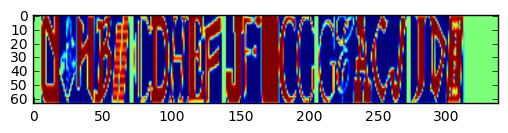

Testing examples


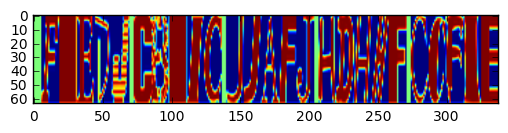

In [11]:
#View a few random examples to make sure everything worked out.
print("Training examples")
showData(train_dataset, train_labels, image_size, num_channels)
print("Testing examples")
showData(test_dataset, test_labels, image_size, num_channels)

In [11]:
#Some syntax in model from: https://elitedatascience.com/keras-tutorial-deep-learning-in-python
#I like combining the activation function and layer into the same statement...
#Syntax for multiple inputs and outputs from:
#https://keras.io/getting-started/functional-api-guide/

def makeDigitModel():
    image_input = Input(shape = (image_size, image_size, num_channels))
    model= Sequential()
    model.add(Dropout(0.2, input_shape=(image_size, image_size, num_channels)))
    model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu'))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())    
    model.add(Dense(3072, activation='relu'))
    digit_model = model(image_input)
    output1 = Dense(11, activation='softmax')(digit_model)
    output2 = Dense(11, activation='softmax')(digit_model)
    output3 = Dense(11, activation='softmax')(digit_model)
    output4 = Dense(11, activation='softmax')(digit_model)
    output5 = Dense(11, activation='softmax')(digit_model)
    output6 = Dense(11, activation='softmax')(digit_model)
    return Model(input=image_input, output=[output1, output2, output3, output4, output5, output6])

In [13]:
adam = Adam(lr=0.0001)
final_syn_model = makeDigitModel()
final_syn_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

encoded_train_labels = encode_labels(train_labels)
 
stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto')

final_syn_model.fit(train_dataset, [encoded_train_labels[:,0,:], encoded_train_labels[:,1,:],encoded_train_labels[:,2,:],
                                encoded_train_labels[:,3,:],encoded_train_labels[:,4,:],encoded_train_labels[:,5,:]
                                ], callbacks=[stopping], nb_epoch=200, verbose=1,batch_size=512)
print("Saving synthetic digit model")
final_syn_model.save('syn_data_model_combined.hdf5')

/home/solinvicta/anaconda2/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


Epoch 1/200
50000/50000 [==============================] - 74s - loss: 12.0046 - dense_2_loss: 0.5019 - dense_3_loss: 2.2801 - dense_4_loss: 2.3099 - dense_5_loss: 2.3031 - dense_6_loss: 2.3021 - dense_7_loss: 2.3076 - dense_2_acc: 0.9187 - dense_3_acc: 0.1672 - dense_4_acc: 0.1261 - dense_5_acc: 0.1238 - dense_6_acc: 0.1213 - dense_7_acc: 0.1202    
Epoch 2/200
50000/50000 [==============================] - 67s - loss: 8.2844 - dense_2_loss: 0.0193 - dense_3_loss: 1.6971 - dense_4_loss: 1.6214 - dense_5_loss: 1.6343 - dense_6_loss: 1.6408 - dense_7_loss: 1.6715 - dense_2_acc: 0.9951 - dense_3_acc: 0.4106 - dense_4_acc: 0.4643 - dense_5_acc: 0.4639 - dense_6_acc: 0.4606 - dense_7_acc: 0.4494    
Epoch 3/200
50000/50000 [==============================] - 67s - loss: 5.8460 - dense_2_loss: 0.0095 - dense_3_loss: 1.2706 - dense_4_loss: 1.1259 - dense_5_loss: 1.1506 - dense_6_loss: 1.1523 - dense_7_loss: 1.1371 - dense_2_acc: 0.9982 - dense_3_acc: 0.5961 - dense_4_acc: 0.6786 - dense_5_acc

In [14]:
#Reload model from hdf5 files
final_syn_model = load_model('syn_data_model_combined.hdf5')
print("Synthetic data model reloaded")
encoded_test_labels = encode_labels(test_labels)
final_syn_model.evaluate(test_dataset, [encoded_test_labels[:,0,:], encoded_test_labels[:,1,:],encoded_test_labels[:,2,:],
                                encoded_test_labels[:,3,:],encoded_test_labels[:,4,:],encoded_test_labels[:,5,:]
                                ], verbose=1)


Synthetic data model reloaded
2000/2000 [==============================] - 1s     


[4.7964478664398191,
 0.0045689494619333571,
 0.97468150582909585,
 0.84532802301645282,
 0.95744663547724485,
 0.9198199965935201,
 1.0946027658618986,
 0.99850000000000005,
 0.88849999999999996,
 0.89049999999999996,
 0.88300000000000001,
 0.88849999999999996,
 0.86150000000000004]

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**  First, I looked into some of the feed-forward and convolutional networks in the lecture examples, and attempted to adapt them, but at the time, I don't think I really understood the architecture. Someone in the forum suggested the Goodfellow paper, and I found that to be useful for figuring out how to label the data (my first version had a single label, rather than digit-position labels) and to organize the classifiers.  But I still didn't have much idea about implementing the neural net itself.

I wound up looking around the forums, and joined the Deep Learning Slack group, and got the suggestion to investigate the Keras library.  I looked into this, and also reviewed the Stanford lectures on neural nets.  All the suggestions were that convolutional networks were especially good for images, so I decided to focus on convolutional neural networks, rather than standard feed-forward architecture.

Once I reviewed these a few times, I started to understand how the building blocks went together, and tried a Keras implementation.  This fell flat a few times until I fixed two things - first, changing the final output of the connected layer to "softmax" rather than relu (which was more appropriate for a categorical variable choice), and then fixing the layering so that I only specified the first layer size in the model.

I also messed around with different representations of the image.  I was original resizing to 28 by 28, but I think this compressed the image too much, so I switched to 64 x 64...this stretches the image in one direction, but from my reading, convolutional networks don't seem to be too troubled by this kind of distortion, and tend to work on square images.

I later revisited my model - it turned out that the way I was training the model, having an array of independently trained models, was fairly inefficient, since the different digit recognition wasn't "sharing" information during the training.  I scraped my original architecture, which had a separate model for each digit, and redesigned the model to produce multiple outputs from a single model.  This model could be trained at once to produce the full output.  Performance on training the new model was a little slow, so I removed some of the convolutional layers to speed things up.  I'd also made an initial error in specifying the output layer, so that they were somehow linked by weight - this kept the accuracy below 30%.  Once I'd fixed this and respecified the outputs, the accuracy again jumped quickly to >85% for all digit positions and to near 100% for the number of digits.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**  My final architecture is a convolutional net.  I built a function at one point so that I could tinker with the numbers of layers easily, but typically have been using 2 convo layers for speed.  Each has a relu activation.  I use max pooling and dropout (0.25) before flattening the data and passing it to a fully connected layer, following by another 6 output layers with a softmax function to assign the final categories.

This architecture is based roughly on Goodfellow's paper, and seems to be a good way to structure things (rather than having thousands of labels...)

The accuracy of the model was typically ~85% on each digit, and near perfect for the length of the number.  This makes sense, since the pattern used for blanks for was consistent and not at all noisy (i.e. - all zeroes)

The models were trained for up to 200 epochs, but were permitted to stop if loss didn't improve significantly for 10 epochs.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**  I trained the model on the notMNIST data set, since I'd already prepared it for earlier assignments.  I built a few functions - one generates a random sequence of up to five digits (by concatenating individual digits) and returns the labels for this sequence.  The other lets you fill an array with this data.

Originally, I was generating arrays of size 140 x 28, but changed these by resizing them to 28 x 28 - I was reading that convolutional networks deal best with square input data, and thought this might also be fine for dealing with the realistic data later.  I changed this later to 64 by 64 to not overly compress longer sequences.

Example synthetic data


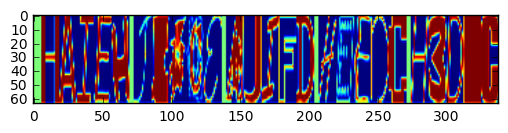

In [15]:
print("Example synthetic data")
showData(train_dataset, train_labels, image_size, 1)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
#Change some parameters used for the realistic data set - now we're dealing with color
image_size = 64  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
num_channels = 3

In [17]:
train_dataset = load_number(train_folder)
test_dataset = load_number(test_folder)

/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/train/
Full dataset tensor: (33402, 64, 64, 3)
Mean: 136.86
Standard deviation: 64.2357
/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/test/
Full dataset tensor: (13068, 64, 64, 3)
Mean: 126.182
Standard deviation: 69.2201


In [18]:
train_labels = get_digit_labels('digitStruct_train.csv')
test_labels = get_digit_labels('digitStruct_test.csv')

print('Training set labels', train_labels.shape)
print('Test set labels', test_labels.shape)


/home/solinvicta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training set labels (33402, 6)
Test set labels (13068, 6)


In [19]:
#Randomize the order of the data and corresponding labels
print('Randomizing the order of the data for convolutional models...')

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

print('Reformatting the shape of the data for convolutional models...')
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Randomizing the order of the data for convolutional models...
Reformatting the shape of the data for convolutional models...
Training set (33402, 64, 64, 3) (33402, 6)
Test set (13068, 64, 64, 3) (13068, 6)


In [20]:
#Dump out the data into  files for fast loading later

#Switched to H5PY from pickle due to errors pickling large data files
h5f = h5py.File('street_view_data.hdf5', 'w')
h5f.create_dataset('test_dataset', data=test_dataset)
h5f.create_dataset('train_dataset', data=train_dataset)
h5f.create_dataset('test_labels', data=test_labels)
h5f.create_dataset('train_labels', data=train_labels)
h5f.close()
print('Data stored to H5F')


Data stored to H5F


In [21]:
#Load up the H5PY data - saves time during repeated runs
h5f = h5py.File('street_view_data.hdf5','r')
test_dataset = h5f['test_dataset'][:]
train_dataset = h5f['train_dataset'][:]
test_labels = h5f['test_labels'][:]
train_labels = h5f['train_labels'][:]
print('Data reloaded from H5F')
h5f.close()


Data reloaded from H5F


Training data examples


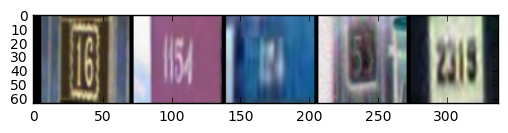

Testing data examples


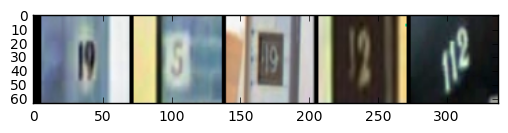

In [22]:
#View a few random examples to make sure everything worked out.
print("Training data examples")
showData(train_dataset, train_labels, image_size, num_channels)
print("Testing data examples")
showData(test_dataset, test_labels, image_size, num_channels)

In [23]:
final_street_model = makeDigitModel()

adam = Adam(lr=0.0001)
final_street_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

encoded_train_labels = encode_labels(train_labels)
 
stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto')

final_street_model.fit(train_dataset, [encoded_train_labels[:,0,:], encoded_train_labels[:,1,:],encoded_train_labels[:,2,:],
                                encoded_train_labels[:,3,:],encoded_train_labels[:,4,:],encoded_train_labels[:,5,:]
                                ], callbacks=[stopping], nb_epoch=3000, verbose=1,batch_size=512)

final_street_model.save('street_view_data_model_combined.hdf5')
print("Street view model saved")

Epoch 1/3000
33402/33402 [==============================] - 49s - loss: 7.5530 - dense_9_loss: 1.1943 - dense_10_loss: 0.1156 - dense_11_loss: 0.3642 - dense_12_loss: 1.2482 - dense_13_loss: 2.3158 - dense_14_loss: 2.3149 - dense_9_acc: 0.5264 - dense_10_acc: 0.9695 - dense_11_acc: 0.9420 - dense_12_acc: 0.6845 - dense_13_acc: 0.1575 - dense_14_acc: 0.1092    
Epoch 2/3000
33402/33402 [==============================] - 46s - loss: 6.8026 - dense_9_loss: 0.9884 - dense_10_loss: 0.0046 - dense_11_loss: 0.2189 - dense_12_loss: 1.0761 - dense_13_loss: 2.2245 - dense_14_loss: 2.2901 - dense_9_acc: 0.5747 - dense_10_acc: 0.9997 - dense_11_acc: 0.9569 - dense_12_acc: 0.6970 - dense_13_acc: 0.2100 - dense_14_acc: 0.1318    
Epoch 3/3000
33402/33402 [==============================] - 46s - loss: 6.2563 - dense_9_loss: 0.8469 - dense_10_loss: 0.0045 - dense_11_loss: 0.1894 - dense_12_loss: 0.9995 - dense_13_loss: 2.0434 - dense_14_loss: 2.1726 - dense_9_acc: 0.6396 - dense_10_acc: 0.9997 - dense

In [24]:
#Reload data if necessary
final_street_model = load_model('street_view_data_model_combined.hdf5')
print("Street view model reloaded")
encoded_test_labels = encode_labels(test_labels)

final_street_model.evaluate(test_dataset, [encoded_test_labels[:,0,:], encoded_test_labels[:,1,:],encoded_test_labels[:,2,:],
                                encoded_test_labels[:,3,:],encoded_test_labels[:,4,:],encoded_test_labels[:,5,:]
                                ], verbose=1)



Street view model reloaded
13068/13068 [==============================] - 10s    


[18.904314857321776,
 3.6000601238966499,
 0.0031574307514072326,
 0.19428654893784816,
 2.8165144683900945,
 6.1007020389555713,
 6.189594216400744,
 0.60774410776235221,
 0.99977043158861345,
 0.97597183960820322,
 0.66842669117220832,
 0.37350780534423161,
 0.36003979187621815]

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** To set up this model, I pulled in the testing and training data by downloading and extracting the files to their own folders, and then parsing them into numpy arrays with the code above (which was adapted from the loading procedure for the notMNIST data).  I made a few changes to the imaging along the way - most notably, reducing the color channels to grayscale, resizing all the images to 32 x 32, and normalizing the scale of the grayscale channel.

The labels were pulled in as csv files, and I had some issues that I'd noted with very low accuracy on the first run of the model, which turned out to be mis-mappings between the labels and the data.  I was able to track this down by visualizing the processed data, and eventually correct it.

My training times were fairly slow during early trials (~5 minutes per epoch, per digit), so I wound up installing an nVidia graphics card, and reinstalling Tensorflow to use the GPU.  This cut the training times to 4-6 seconds per epoch (!), and allowed me to experiment with different architectures, eventually moving to a more complicated one back in the range of 45 seconds per epoch.

I re-read the Goodfellow paper (https://arxiv.org/pdf/1312.6082v4.pdf) and started to look into some of the specific architecture there.  The first correction I'd noticed is that I was downsampling the pictures too aggressively.  I switched back to 3-channels, from grayscale, and also changed the image resizing from 32x32 to 64x64.  The specific architecture that they'd mentioned also helped; although they had noticed improvements with increasing the model depth, it seemed that it gave somewhat diminishing returns after 6 layers, so I thought that this might be a fair place for me to set an upper limit to my tests.  When I tried very deep models earlier, I found that they took longer to train, and seemed to converge on local minima, unless I reduce the learning rate quite a bit.  This leads me to thing that it's best to start with a less-deep model to try to get the problem right, and then increase the depth if I'm later trying to squeeze out more accuracy.

I later reverted back to grayscale - this choice seemed to have only a modest effect either way on accuracy, and then returned later to color when I was having some difficulties improving accuracy on the right most digit.  I also reverted to fairly uniform convolutional layers (32, 5x5 filtering)

The model performed quite a bit worse on the realistic data set.  One interesting point is that the position of the numbers seemed to have more of an effect than it did in the synthetic data set.  My guess is that the realistic set is more biased towards shorter numbers and that this is having an effect.  During training, I started to focus model development on the rightmost digit, since this was the one that was giving the lowest accuracy in the test set.

Later, I shifted from using multiple separate models to one single model with multiple outputs, and tried to keep the same architecture (except for the number of channels) that I'd used in the synthetic data.  For the final model, the accuracy varied from >97% for the leftmost digits, down to 36% for the rightmost digits.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**  As noted above, I tried tinkering with the image size and quality (32 versus 64, grayscale versus color), and the number of convolutional layers.  I also tried different combinations of max pooling and dropout, and different convolutional filter sizes.  Adding extra convolutional layers didn't always work the way that I'd expected.  I thought that "more would be better" but this wasn't necessarily true if the image size was too small, or the learning rate too high.

I'd also shifted the position of dropout.  Although this wasn't used in the original Goodfellow paper, I wanted to experiment with it.  Originally, I'd put fairly high dropout in the hidden layers, and moved towards a smaller amount of dropout near the input.  As I'd mentioned earlier, I also changed from multiple models, to a single model with multiple outputs.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**  My initial results were almost as bad as chance in some cases. With the improvements in the model, it seems to be doing a better job at classifying numbers...however, it is still falling very much short of the benchmark set by the Goodfellow paper.  There are a number of contributing factors that I can think of to the success of the paper's model, including - use of a larger training set, setting the bounding boxes to be tightly around the images, rather than using the whole image, and possibly expanding the training set size by augmenting with jittered / resized data.  The current model would NOT be sufficient to use for street-view annotation.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [25]:
#This section loads the data from the 10 newly captured house numbers from my neighborhood
new_dataset = load_number(new_folder)
new_labels = get_digit_labels('digitStruct_new.csv') #created this file, modeled on earlier files

print('Newly captured data set labels', new_labels.shape)


/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/houses/
Full dataset tensor: (10, 64, 64, 3)
Mean: 156.35
Standard deviation: 67.4314
Newly captured data set labels (10, 6)


In [26]:
#Reload models from hdf5 files
encoded_new_labels = encode_labels(new_labels)

final_street_model = load_model('street_view_data_model_combined.hdf5')
print("Street view model reloaded")

final_street_model.evaluate(new_dataset, [encoded_new_labels[:,0,:], encoded_new_labels[:,1,:],encoded_new_labels[:,2,:],
                                encoded_new_labels[:,3,:],encoded_new_labels[:,4,:],encoded_new_labels[:,5,:]
                                ], verbose=1)

Street view model reloaded
10/10 [==============================] - 0s


[29.080707550048828,
 7.0820202827453613,
 1.1920930376163597e-07,
 0.0020012953318655491,
 4.6134576797485352,
 7.6388397216796875,
 9.7443876266479492,
 0.30000001192092896,
 1.0,
 1.0,
 0.30000001192092896,
 0.10000000149011612,
 0.0]

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

Newly captured images


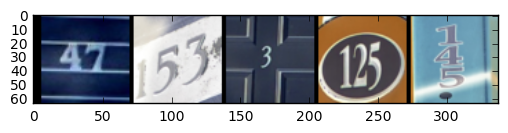

In [36]:
print("Newly captured images")
showData(new_dataset, new_labels, image_size, num_channels)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** No, it's actually performing very poorly on the critical "right-most" digits.  This is probably due to a combination of closer cropping on these images, and artifacts that might be causing trouble.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
train_image_sizes = load_sizes(train_folder)
test_image_sizes = load_sizes(test_folder)

/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/train/
Full image size tensor: (33402, 3)
Mean: Width     128.284983
Height     57.213011
dtype: float64
Standard deviation: Width     80.545012
Height    36.179155
dtype: float64
/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/test/
Full image size tensor: (13068, 3)
Mean: Width     172.583486
Height     71.566498
dtype: float64
Standard deviation: Width     122.581756
Height     52.750334
dtype: float64


In [4]:
#The bounding box data comes from a parsed version of the .mat data, found here:
train_box_labels = get_box_labels('digitStruct_train.csv', train_image_sizes)
test_box_labels = get_box_labels('digitStruct_test.csv', test_image_sizes )

print('Training set labels', train_box_labels.shape)
print('Test set labels', test_box_labels.shape)

Training set labels (33402, 4)
Test set labels (13068, 4)


In [5]:
train_dataset = load_number(train_folder)
train_cropped_dataset = load_number(train_folder, train_box_labels)
test_dataset = load_number(test_folder)
test_cropped_dataset = load_number(test_folder, test_box_labels)

/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/train/
Full dataset tensor: (33402, 64, 64, 3)
Mean: 136.86
Standard deviation: 64.2357
/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/train/
small box width 60


/home/solinvicta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:133: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


small box width 83
small box width 2445
small box width 2649
small box width 2745
small box width 4051
small box width 4089
small box width 5875
small box width 6819
small box width 7793
small box width 8626
small box width 8756
small box width 8810
small box width 8961
small box width 9072
small box width 9417
small box width 9816
small box width 10487
small box width 10651
small box width 11950
small box width 12414
small box width 12628
small box width 13443
small box width 14046
small box width 14313
small box width 14444
small box width 14723
small box width 15820
small box width 16806
small box width 16999
small box width 17176
small box width 17429
small box width 17549
small box width 17922
small box width 18164
small box width 18320
small box width 18400
small box width 18761
small box width 20995
small box width 21206
small box width 21984
small box width 22101
small box width 22298
small box width 23076
small box width 23226
small box width 24558
small box width 26170
small 

In [6]:
train_labels = get_digit_labels('digitStruct_train.csv')
test_labels = get_digit_labels('digitStruct_test.csv')

print('Training set labels', train_labels.shape)
print('Test set labels', test_labels.shape)


/home/solinvicta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training set labels (33402, 6)
Test set labels (13068, 6)


In [7]:
#Randomize the order of the data and corresponding labels
print('Randomizing the order of the data for convolutional models...')

train_dataset, train_labels, train_box_labels, train_cropped_dataset  = randomize(train_dataset, train_labels, train_box_labels, train_cropped_dataset)
#Shouldn't be a need to randomize test
#test_dataset, test_labels, test_box_labels = randomize(test_dataset, test_labels, test_box_labels)

print('Reformatting the shape of the data for convolutional models...')
train_dataset, train_labels = reformat(train_dataset, train_labels)
train_cropped_dataset, train_labels = reformat(train_cropped_dataset, train_labels)
test__dataset, test_labels = reformat(test_dataset, test_labels)
test_cropped_dataset, test_labels = reformat(test_cropped_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Training cropped set', train_cropped_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Test cropped set', train_cropped_dataset.shape, train_labels.shape)

Randomizing the order of the data for convolutional models...
Reformatting the shape of the data for convolutional models...
Training set (33402, 64, 64, 3) (33402, 6)
Training cropped set (33402, 64, 64, 3) (33402, 6)
Test set (13068, 64, 64, 3) (13068, 6)
Test cropped set (33402, 64, 64, 3) (33402, 6)


In [8]:
#Dump out the data into  files for fast loading later

#Switched to H5PY from pickle due to errors pickling large data files
h5f = h5py.File('street_view_cropped_data.hdf5', 'w')
h5f.create_dataset('test_dataset', data=test_dataset)
h5f.create_dataset('train_cropped_dataset', data=train_cropped_dataset)
h5f.create_dataset('train_dataset', data=train_dataset)
h5f.create_dataset('test_cropped_dataset', data=test_cropped_dataset)
h5f.create_dataset('test_labels', data=test_labels)
h5f.create_dataset('train_labels', data=train_labels)
h5f.create_dataset('test_box_labels', data=test_box_labels)
h5f.create_dataset('train_box_labels', data=train_box_labels)

h5f.close()
print('Data stored to H5F')

Data stored to H5F


In [4]:
#Load up the H5PY data - saves time during repeated runs
h5f = h5py.File('street_view_cropped_data.hdf5','r')
test_dataset = h5f['test_dataset'][:]
train_dataset = h5f['train_dataset'][:]
test_labels = h5f['test_labels'][:]
train_labels = h5f['train_labels'][:]
train_cropped_dataset = h5f['train_cropped_dataset'][:]
test_cropped_dataset = h5f['test_cropped_dataset'][:]
test_box_labels = h5f['test_box_labels'][:]
train_box_labels = h5f['train_box_labels'][:]
print('Data reloaded from H5F')
h5f.close()


Data reloaded from H5F


Training  data examples


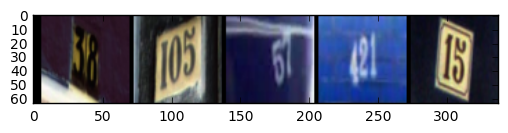

Training cropped data examples


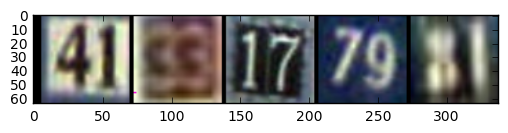

Testing data examples


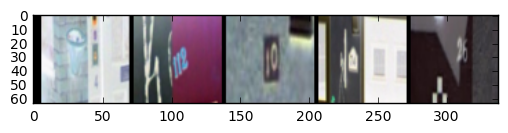

Testing cropped data examples


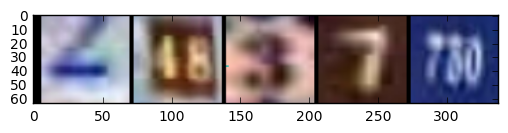

In [5]:
print("Training  data examples")
showData(train_dataset, train_labels, image_size, num_channels)
print("Training cropped data examples")
showData(train_cropped_dataset, train_labels, image_size, num_channels)
print("Testing data examples")
showData(test_dataset, test_labels, image_size, num_channels)
print("Testing cropped data examples")
showData(test_cropped_dataset, test_labels, image_size, num_channels)

In [11]:
#Bounding box model
def makeBoxModel():
    image_input = Input(shape = (image_size, image_size, num_channels))
    model= Sequential()
    model.add(Dropout(0.2, input_shape=(image_size, image_size, num_channels)))
    model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu'))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())    
    model.add(Dense(1028, activation='relu'))
    box_model = model(image_input)
    left = Dense(1, activation='linear')(box_model)
    top = Dense(1, activation='linear')(box_model)
    right = Dense(1, activation='linear')(box_model)
    bottom = Dense(1, activation='linear')(box_model)
    return Model(input=image_input, output=[left, top, right, bottom])

adam = Adam(lr=.0001)
stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto')

final_box_model = makeBoxModel()
final_box_model.compile(loss="mse", optimizer=adam)
final_box_model.fit(train_dataset, [train_box_labels[:,0],train_box_labels[:,1], 
                                    train_box_labels[:,2], train_box_labels[:,3]], 
                                    nb_epoch=200, callbacks=[stopping], verbose=1,batch_size=512)

final_box_model.save('street_view_box_model_combined.hdf5')
print("Final box model model saved")

#Alternate, IOU-loss-based model.  Did not converge
#final_box_model = Model(input=image_input, output=output)
#final_box_model.compile(loss=batch_iou, optimizer=adam)
#final_box_model.fit(train_dataset[0:500,:,:,:], train_box_labels[0:500,:], nb_epoch=10, verbose=1,batch_size=512)
#Alternate, IOU-loss fit
#final_box_model.fit(train_dataset, train_box_labels, nb_epoch=2, verbose=1,batch_size=64)



Epoch 1/200
33402/33402 [==============================] - 51s - loss: 0.1530 - dense_2_loss: 0.0222 - dense_3_loss: 0.0185 - dense_4_loss: 0.0412 - dense_5_loss: 0.0711    
Epoch 2/200
33402/33402 [==============================] - 45s - loss: 0.0483 - dense_2_loss: 0.0080 - dense_3_loss: 0.0091 - dense_4_loss: 0.0125 - dense_5_loss: 0.0187    
Epoch 3/200
33402/33402 [==============================] - 45s - loss: 0.0399 - dense_2_loss: 0.0068 - dense_3_loss: 0.0084 - dense_4_loss: 0.0100 - dense_5_loss: 0.0147    
Epoch 4/200
33402/33402 [==============================] - 45s - loss: 0.0350 - dense_2_loss: 0.0061 - dense_3_loss: 0.0079 - dense_4_loss: 0.0085 - dense_5_loss: 0.0125    
Epoch 5/200
33402/33402 [==============================] - 45s - loss: 0.0298 - dense_2_loss: 0.0054 - dense_3_loss: 0.0075 - dense_4_loss: 0.0068 - dense_5_loss: 0.0100    
Epoch 6/200
33402/33402 [==============================] - 45s - loss: 0.0266 - dense_2_loss: 0.0050 - dense_3_loss: 0.0072 - dens

In [6]:
final_box_model = load_model('street_view_box_model_combined.hdf5')
print("Final box model model reloaded")

final_box_model.evaluate(test_dataset,[test_box_labels[:,0],test_box_labels[:,1], 
                                             test_box_labels[:,2], test_box_labels[:,3]], verbose=1,batch_size=512)


Final box model model reloaded
13068/13068 [==============================] - 8s     


[0.04097693481456624,
 0.0064664753313559186,
 0.015482700238004897,
 0.0061624059815645069,
 0.012865353005652877]

In [7]:
#Predict bounding boxes for the test set using the trained model for bounding box prediction, then crop / reload the data
test_pred_box_labels = final_box_model.predict(test_dataset, verbose=1)
test_pred_cropped_dataset = load_number(test_folder, test_pred_box_labels)
test_pred_cropped_dataset, test_labels = reformat(test_pred_cropped_dataset, test_labels)
print("Predicted and reloaded test data")


13068/13068 [==============================] - 8s     
/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/test/


/home/solinvicta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:134: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Full dataset tensor: (13068, 64, 64, 3)
Mean: 132.022
Standard deviation: 67.4757


Test predicted cropped data examples


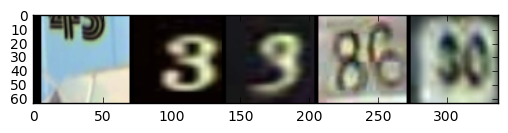

In [8]:
print("Test predicted cropped data examples")
showData(test_pred_cropped_dataset, test_labels, image_size, num_channels)

In [9]:
#Dump out the data into  files for fast loading later; seems like there should be a way to append rather than overwrite
#but this will do for now!

#Switched to H5PY from pickle due to errors pickling large data files
h5f = h5py.File('street_view_cropped_data.hdf5', 'w')
h5f.create_dataset('test_dataset', data=test_dataset)
h5f.create_dataset('train_cropped_dataset', data=train_cropped_dataset)
h5f.create_dataset('train_dataset', data=train_dataset)
h5f.create_dataset('test_labels', data=test_labels)
h5f.create_dataset('train_labels', data=train_labels)
h5f.create_dataset('test_box_labels', data=test_box_labels)
h5f.create_dataset('train_box_labels', data=train_box_labels)
h5f.create_dataset('test_cropped_dataset', data=test_cropped_dataset)
h5f.create_dataset('test_pred_cropped_dataset', data=test_pred_cropped_dataset)
h5f.create_dataset('test_pred_box_labels', data=test_pred_box_labels)

h5f.close()
print('Data stored to H5F')

Data stored to H5F


In [15]:
#Reuse the street view model, but this time, build it with the cropped training data
final_street_model = makeDigitModel()

adam = Adam(lr=0.0001)
final_street_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

encoded_train_labels = encode_labels(train_labels)

stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto')

final_street_model.fit(train_cropped_dataset, [encoded_train_labels[:,0,:], encoded_train_labels[:,1,:],encoded_train_labels[:,2,:],
                                encoded_train_labels[:,3,:],encoded_train_labels[:,4,:],encoded_train_labels[:,5,:]
                                ], callbacks=[stopping], nb_epoch=200, verbose=1,batch_size=512)
print("I cut the epoches short to avoid retraining, but left it in to demonstrate that this cell runs")
#final_street_model.save('street_view_cropped_model_combined.hdf5')
#print("Street view model saved")
    


Epoch 1/2
33402/33402 [==============================] - 49s - loss: 7.5978 - dense_9_loss: 1.2264 - dense_10_loss: 0.1128 - dense_11_loss: 0.3739 - dense_12_loss: 1.2611 - dense_13_loss: 2.3103 - dense_14_loss: 2.3133 - dense_9_acc: 0.5165 - dense_10_acc: 0.9851 - dense_11_acc: 0.9421 - dense_12_acc: 0.6772 - dense_13_acc: 0.1639 - dense_14_acc: 0.1110    
Epoch 2/2
33402/33402 [==============================] - 46s - loss: 6.5092 - dense_9_loss: 0.8963 - dense_10_loss: 0.0045 - dense_11_loss: 0.2162 - dense_12_loss: 1.0329 - dense_13_loss: 2.1395 - dense_14_loss: 2.2198 - dense_9_acc: 0.6258 - dense_10_acc: 0.9997 - dense_11_acc: 0.9568 - dense_12_acc: 0.7008 - dense_13_acc: 0.2603 - dense_14_acc: 0.1811    
I cut the epoches short to avoid retraining, but left it in to demonstrate that this cell runs


In [13]:
#Reload models from hdf5 files
cropped_models = []

#Reload model from hdf5 files
final_street_model = load_model('street_view_cropped_model_combined.hdf5')
print("Cropped street model reloaded")
encoded_test_labels = encode_labels(test_labels)
final_street_model.evaluate(test_pred_cropped_dataset, [encoded_test_labels[:,0,:], encoded_test_labels[:,1,:],encoded_test_labels[:,2,:],
                                encoded_test_labels[:,3,:],encoded_test_labels[:,4,:],encoded_test_labels[:,5,:]
                                ], verbose=1)

Cropped street model reloaded
13068/13068 [==============================] - 10s    


[15.161915616519158,
 2.8955435514960919,
 0.002467450597737909,
 0.14421734733020608,
 1.8239971698151476,
 5.0621935535287284,
 5.2334964521295406,
 0.66804407717147518,
 0.99984695439240889,
 0.98178757269666361,
 0.79162840528301337,
 0.5022956841229882,
 0.47375267830725509]

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**  Looking at sample of the number localization in the realistic dataset, it seemed to be performing well.  There were a few changes that I had to make to the initial model to get this to work - changing the activation functions on the output (since softmax isn't appropriate for regression), and also scaling the data appropriately.  There were still some cases where the model failed outright, such as predicting a bounding box with a 0 dimension.  In these cases, I ignore the bounding box for cropping the image in this direction.  I actually made it a little looser than just 0, since I'd imagine a picture of less than 5 pixels in a particular direction is not informative.

To see if the classification results would change, I retrained the model on cropped input training data.  My initial run on the test data was not improved; I suspected a problem with the bounding predictions rather than the digit predictions, and re-ran the test, using test data cropped by the "correct" bounding box information from the .mat file.  This indeed improved the predictions.  So, I went back to the bounding box model and tuned it (changing the convolutions from 5 x 5 to 3 x 3, reducing the amount of pooling, expanding the fully-connected layer before the output, and changing from the final function from relu to linear).

As with the earlier models, I'd initially explored using four separate models, one per output, and then changed to a merged model.  I tried implementing a custom loss function at one point based on the IOU metric, combining all four measures; unfortunately, this metric is flat when the boxes don't overlap, so the loss function didn't converge.  I wound up reverting to mse as a loss function.

The model did improve predictions with the bounding boxes; even with far fewer epochs of training, I was getting digit prediction results that were better than with the previous model, especially on the digits with lower accuracy before.  I'm still a little nervous, based on inspecting some of the data, that the bounding box classifer isn't quite right, and that it might be cropping some of the digits too closely.


### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/houses/
Full dataset tensor: (10, 64, 64, 3)
Mean: 156.35
Standard deviation: 67.4314
Newly captured data set labels (10, 6)
10/10 [==============================] - 0s
/media/solinvicta/Big_Storage/udacity/machine-learning/projects/digit_recognition/houses/
Full dataset tensor: (10, 64, 64, 3)
Mean: 157.392
Standard deviation: 67.6025
New data full examples


/home/solinvicta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:134: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


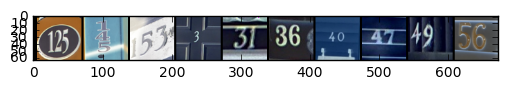

New data cropped data examples


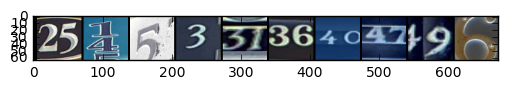

In [14]:
#This section loads the data from the 10 newly captured house numbers from my neighborhood
new_dataset = load_number(new_folder)
new_labels = get_digit_labels('digitStruct_new.csv') #created this file, modeled on earlier files

print('Newly captured data set labels', new_labels.shape)

#Predict bounding boxes for the captured set using the trained model for bounding box prediction
new_pred_box_labels = final_box_model.predict(new_dataset, verbose=1)
new_cropped_dataset = load_number(new_folder, new_pred_box_labels)

print("New data full examples")
showData(new_dataset, new_labels, image_size, num_channels, examples=range(10))
#print(new_pred_box_labels)
print("New data cropped data examples")
showData(new_cropped_dataset, new_labels, image_size, num_channels, examples=range(10))

**Answer:**  The bounding box function seems to localize the digits, but gets thrown off by other things (shadows, etc) easily.  The cropping seems to be too aggressive on most of these images; the boxes are too tight for the digits themselves.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
(skipped this optional section)

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.